<a href="https://colab.research.google.com/github/OmarMohammed88/AR-Emotion-Recognition/blob/main/notebooks%20/Hubert/%20Hubert_AR_EmotionRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emotion Recognition in Greek Speech Using HuBERT

In [ ]:
!nvidia-smi

Wed Sep 15 00:00:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# from google.colab import drive

# drive.mount('/content/drive', force_remount=True)

In [ ]:
%%capture

!pip install git+https://github.com/huggingface/datasets.git
!pip install git+https://github.com/huggingface/transformers.git
!pip install torchaudio
!pip install librosa

# Monitor the training process
# !pip install wandb

In [ ]:
# # Uncomment this part if you want to setup your wandb project

# %env WANDB_WATCH=all
# %env WANDB_LOG_MODEL=1
# %env WANDB_PROJECT=YOUR_PROJECT_NAME
# !wandb login YOUR_API_KEY --relogin

In [ ]:
!gdown --id 1dGEhcc3hjtZKMkojdLxdSGYo2Nk4UJxF
!unrar e /content/EYASE.rar -d data/


In [ ]:
import numpy as np
import pandas as pd

from pathlib import Path
from tqdm import tqdm

import torchaudio
from sklearn.model_selection import train_test_split

import os
import sys

In [ ]:
df = pd.read_csv("/content/EYASE_DF.csv")
df.head()

,name,emotion
0,/content/data/fm01_hap (3).wav,hap
1,/content/data/fm01_ang (6).wav,ang
2,/content/data/fm01_hap (2).wav,hap
3,/content/data/ml02_hap (15).wav,hap
4,/content/data/ml03_neu (19).wav,neu


In [ ]:
data_li = []

for i in tqdm(range(len(df))):
    name = df['name'][i]
    label = df['emotion'][i]
    
    try:
        # There are some broken files
        s = torchaudio.load(name)
        data_li.append({
            "name": name,
            "emotion": label
        })
    except Exception as e:
        # print(str(path), e)
        pass

    # break
df = pd.DataFrame(data_li)
df.head()

100%|██████████| 499/499 [00:00<00:00, 1114.40it/s]


,name,emotion
0,/content/data/fm01_hap (3).wav,hap
1,/content/data/fm01_ang (6).wav,ang
2,/content/data/fm01_hap (2).wav,hap
3,/content/data/ml02_hap (15).wav,hap
4,/content/data/ml03_neu (19).wav,neu


In [ ]:
import torchaudio
import librosa
import IPython.display as ipd
import numpy as np

idx = np.random.randint(0, len(df))
sample = df.iloc[idx]
path = sample["name"]
label = sample["emotion"]


print(f"ID Location: {idx}")
print(f"      Label: {label}")
print()

speech, sr = torchaudio.load(path)
speech = speech[0].numpy().squeeze()
speech = librosa.resample(np.asarray(speech), sr, 16_000)
ipd.Audio(data=np.asarray(speech), autoplay=True, rate=16000)

ID Location: 149
      Label: neu



For training purposes, we need to split data into train test sets; in this specific example, we break with a `20%` rate for the test set.

In [ ]:
save_path = "/content/"

train_df, test_df = train_test_split(df, test_size=0.2, random_state=101, stratify=df["emotion"])

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_df.to_csv(f"{save_path}/train.csv", sep="\t", encoding="utf-8", index=False)
test_df.to_csv(f"{save_path}/test.csv", sep="\t", encoding="utf-8", index=False)


print(train_df.shape)
print(test_df.shape)

(399, 2)
(100, 2)


## Prepare Data for Training

In [ ]:
# Loading the created dataset using datasets
from datasets import load_dataset, load_metric


data_files = {
    "train": "/content/train.csv", 
    "validation": "/content/test.csv",
}

dataset = load_dataset("csv", data_files=data_files, delimiter="\t", )
train_dataset = dataset["train"]
eval_dataset = dataset["validation"]

print(train_dataset)
print(eval_dataset)

  0%|          | 0/2 [00:00<?, ?it/s]

Using custom data configuration default-4e0a7ce69facc838


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-4e0a7ce69facc838/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Dataset({
    features: ['name', 'emotion'],
    num_rows: 399
})
Dataset({
    features: ['name', 'emotion'],
    num_rows: 100
})


In [ ]:
# We need to specify the input and output column
input_column = "name"
output_column = "emotion"

In [ ]:
# we need to distinguish the unique labels in our SER dataset
label_list = train_dataset.unique(output_column)
label_list.sort()  # Let's sort it for determinism
num_labels = len(label_list)
print(f"A classification problem with {num_labels} classes: {label_list}")

A classification problem with 4 classes: ['ang', 'hap', 'neu', 'sad']


In [ ]:
from transformers import AutoConfig, Wav2Vec2Processor, Wav2Vec2FeatureExtractor

In [ ]:
model_name_or_path = "facebook/hubert-base-ls960"
pooling_mode = "mean"

In [ ]:
# config
config = AutoConfig.from_pretrained(
    model_name_or_path,
    num_labels=num_labels,
    label2id={label: i for i, label in enumerate(label_list)},
    id2label={i: label for i, label in enumerate(label_list)},
    finetuning_task="wav2vec2_clf",
)
setattr(config, 'pooling_mode', pooling_mode)

Downloading:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

In [ ]:
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name_or_path,)
target_sampling_rate = feature_extractor.sampling_rate
print(f"The target sampling rate: {target_sampling_rate}")

Downloading:   0%|          | 0.00/213 [00:00<?, ?B/s]

The target sampling rate: 16000


# Preprocess Data

In [ ]:
def speech_file_to_array_fn(path):
    speech_array, sampling_rate = torchaudio.load(path)
    resampler = torchaudio.transforms.Resample(sampling_rate, target_sampling_rate)
    speech = resampler(speech_array).squeeze().numpy()
    return speech

def label_to_id(label, label_list):

    if len(label_list) > 0:
        return label_list.index(label) if label in label_list else -1

    return label

def preprocess_function(examples):
    speech_list = [speech_file_to_array_fn(path) for path in examples[input_column]]
    target_list = [label_to_id(label, label_list) for label in examples[output_column]]

    result = feature_extractor(speech_list, sampling_rate=target_sampling_rate)
    result["labels"] = list(target_list)

    return result

In [ ]:
train_dataset = train_dataset.map(
    preprocess_function,
    batch_size=100,
    batched=True,
    num_proc=4
)
eval_dataset = eval_dataset.map(
    preprocess_function,
    batch_size=100,
    batched=True,
    num_proc=4
)

In [ ]:
idx = 0
print(f"Training input_values: {train_dataset[idx]['input_values']}")
# print(f"Training attention_mask: {train_dataset[idx]['attention_mask']}")
print(f"Training labels: {train_dataset[idx]['labels']} - {train_dataset[idx]['emotion']}")

Training input_values: [0.31270694732666016, 0.448386013507843, 0.34739962220191956, 0.3138628304004669, 0.2879815101623535, 0.2959243059158325, 0.3118579089641571, 0.28443634510040283, 0.23162677884101868, 0.2100515514612198, 0.1728227436542511, 0.11549415439367294, 0.059344660490751266, 0.03800702467560768, 0.02057836949825287, -0.019718434661626816, -0.013735145330429077, 0.007304893806576729, 0.029172519221901894, 0.1101863756775856, 0.12848961353302002, 0.07596760988235474, 0.14582118391990662, 0.16221174597740173, 0.23916535079479218, 0.34846118092536926, 0.256364107131958, 0.20620131492614746, 0.1879006177186966, 0.1416279673576355, 0.15437355637550354, 0.09177453815937042, 0.058542437851428986, 0.005938852205872536, -0.04791140928864479, -0.06227484717965126, -0.12198002636432648, -0.14577996730804443, -0.15703396499156952, -0.1780090481042862, -0.1608126014471054, -0.08579826354980469, -0.09486688673496246, -0.040847357362508774, -0.018642276525497437, -0.02962617389857769, 0.

## Model

In [ ]:
from dataclasses import dataclass
from typing import Optional, Tuple
import torch
from transformers.file_utils import ModelOutput


@dataclass
class SpeechClassifierOutput(ModelOutput):
    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None


In [ ]:
def w_c(train_set: pd.DataFrame, class_col_name) -> torch.Tensor:
    """
    .. math::
        w_c = \frac{1/n_c}{\sum_{c^'} 1/n_c}

    Args:
        train_set: dataset on which to calculate the class weights
        class_col_name: class column name by which data is grouped

    Returns:
        weights according a weighting function defined above.


    """
    grouped_train_set = train_set.groupby(class_col_name)
    numerator = torch.tensor([1 / g.shape[0] for _, g in grouped_train_set])
    return numerator / numerator.sum()
weights = w_c(train_df,'emotion')
print(weights)

tensor([0.2389, 0.2761, 0.2389, 0.2460])


In [ ]:
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

# from transformers.models.wav2vec2.modeling_wav2vec2 import (
#     Wav2Vec2PreTrainedModel,
#     Wav2Vec2Model
# )
from transformers.models.hubert.modeling_hubert import (
    HubertPreTrainedModel,
    HubertModel
)


class HubertClassificationHead(nn.Module):
    """Head for hubert classification task."""

    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.final_dropout)
        self.out_proj = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, features, **kwargs):
        x = features
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x


class HubertForSpeechClassification(HubertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.pooling_mode = config.pooling_mode
        self.config = config

        self.hubert = HubertModel(config)
        self.classifier = HubertClassificationHead(config)

        self.init_weights()

    def freeze_feature_extractor(self):
        self.hubert.feature_extractor._freeze_parameters()

    def merged_strategy(
            self,
            hidden_states,
            mode="mean"
    ):
        if mode == "mean":
            outputs = torch.mean(hidden_states, dim=1)
        elif mode == "sum":
            outputs = torch.sum(hidden_states, dim=1)
        elif mode == "max":
            outputs = torch.max(hidden_states, dim=1)[0]
        else:
            raise Exception(
                "The pooling method hasn't been defined! Your pooling mode must be one of these ['mean', 'sum', 'max']")

        return outputs

    def forward(
            self,
            input_values,
            attention_mask=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
            labels=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        outputs = self.hubert(
            input_values,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_states = outputs[0]
        hidden_states = self.merged_strategy(hidden_states, mode=self.pooling_mode)
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss(weight = weights.cuda())
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SpeechClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


## Training



In [ ]:
from dataclasses import dataclass
from typing import Dict, List, Optional, Union
import torch

import transformers
from transformers import Wav2Vec2FeatureExtractor


@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        feature_extractor (:class:`~transformers.Wav2Vec2FeatureExtractor`)
            The feature_extractor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    feature_extractor: Wav2Vec2FeatureExtractor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [feature["labels"] for feature in features]

        d_type = torch.long if isinstance(label_features[0], int) else torch.float

        batch = self.feature_extractor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )

        batch["labels"] = torch.tensor(label_features, dtype=d_type)

        return batch

In [ ]:
data_collator = DataCollatorCTCWithPadding(feature_extractor=feature_extractor, padding=True)

In [ ]:
is_regression = False

In [ ]:
import numpy as np
from transformers import EvalPrediction


def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.squeeze(preds) if is_regression else np.argmax(preds, axis=1)

    if is_regression:
        return {"mse": ((preds - p.label_ids) ** 2).mean().item()}
    else:
        return {"accuracy": (preds == p.label_ids).astype(np.float32).mean().item()}

In [ ]:
drive_dir = "/content"
!ls {drive_dir}
output_dir = os.path.join(drive_dir, "ckpts", "EYASE_hubert")
!mkdir {output_dir}

 data	        EYASE.rar     test.csv	 'Untitled Folder'
 EYASE_DF.csv   sample_data   train.csv
mkdir: cannot create directory ‘/content/ckpts/EYASE_hubert’: No such file or directory


In [ ]:
import os
import shutil

last_checkpoint = None
checkpoints = []
if os.path.exists(output_dir):
    for subdir in os.scandir(output_dir):
        if subdir.is_dir():
            checkpoints.append(subdir.path)
            
            
if len(checkpoints) > 0:
    checkpoints = list(sorted(checkpoints, key=lambda ckpt: ckpt.split('/')[-1].split('-')[-1], reverse=True))
    model_name_or_path = os.path.join("/content", checkpoints[0].split("/")[-1])
    last_checkpoint = model_name_or_path
    shutil.copytree(checkpoints[0], model_name_or_path)

In [ ]:
print(f"model_name_or_path: {model_name_or_path}")
print(f"last_checkpoint: {last_checkpoint}")

model_name_or_path: facebook/hubert-base-ls960
last_checkpoint: None


In [ ]:
model = HubertForSpeechClassification.from_pretrained(
    model_name_or_path,
    config=config,
)

Downloading:   0%|          | 0.00/360M [00:00<?, ?B/s]

Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at facebook/hubert-base-ls960 and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.freeze_feature_extractor()

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    evaluation_strategy="steps",
    num_train_epochs=15.0,
    fp16=True,
    save_steps=15,
    eval_steps=15,
    logging_steps=15,
    learning_rate=1e-4,
    save_total_limit=1,
    do_train=True,
    do_eval=True,
    do_predict=True
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
from typing import Any, Dict, Union

import torch
from packaging import version
from torch import nn

from transformers import (
    Trainer,
    is_apex_available,
)

if is_apex_available():
    from apex import amp

if version.parse(torch.__version__) >= version.parse("1.6"):
    _is_native_amp_available = True
    from torch.cuda.amp import autocast


class CTCTrainer(Trainer):
    def training_step(self, model: nn.Module, inputs: Dict[str, Union[torch.Tensor, Any]]) -> torch.Tensor:
        """
        Perform a training step on a batch of inputs.

        Subclass and override to inject custom behavior.

        Args:
            model (:obj:`nn.Module`):
                The model to train.
            inputs (:obj:`Dict[str, Union[torch.Tensor, Any]]`):
                The inputs and targets of the model.

                The dictionary will be unpacked before being fed to the model. Most models expect the targets under the
                argument :obj:`labels`. Check your model's documentation for all accepted arguments.

        Return:
            :obj:`torch.Tensor`: The tensor with training loss on this batch.
        """

        model.train()
        inputs = self._prepare_inputs(inputs)

        if self.use_amp:
            with autocast():
                loss = self.compute_loss(model, inputs)
        else:
            loss = self.compute_loss(model, inputs)

        if self.args.gradient_accumulation_steps > 1:
            loss = loss / self.args.gradient_accumulation_steps

        if self.use_amp:
            self.scaler.scale(loss).backward()
        elif self.use_apex:
            with amp.scale_loss(loss, self.optimizer) as scaled_loss:
                scaled_loss.backward()
        elif self.deepspeed:
            self.deepspeed.backward(loss)
        else:
            loss.backward()

        return loss.detach()


Now, all instances can be passed to Trainer and we are ready to start training!

In [ ]:
trainer = CTCTrainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=feature_extractor,
)

Using amp fp16 backend


### Training

```javascript
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);
```

In [ ]:
if training_args.do_train:
    print(f"last_checkpoint: {last_checkpoint}")
    train_result = trainer.train(resume_from_checkpoint=last_checkpoint)
    trainer.save_model()
    feature_extractor.save_pretrained(training_args.output_dir)
    metrics = train_result.metrics
    metrics["train_samples"] = len(train_dataset)

    trainer.log_metrics("train", metrics)
    trainer.save_metrics("train", metrics)
    trainer.save_state()

The following columns in the training set  don't have a corresponding argument in `HubertForSpeechClassification.forward` and have been ignored: name, emotion.
***** Running training *****
  Num examples = 399
  Num Epochs = 15
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 2
  Total optimization steps = 750


last_checkpoint: None


Step,Training Loss,Validation Loss,Accuracy
15,0.821900,1.592226,0.550000
30,0.902000,1.237801,0.510000
45,0.761300,0.990589,0.610000
60,0.706100,1.019643,0.610000
75,0.566000,1.076267,0.610000
90,1.029300,0.935855,0.590000
105,0.671600,1.038578,0.680000
120,0.709100,1.176649,0.690000
135,0.962100,1.392011,0.580000
150,0.728000,0.961896,0.660000


/usr/local/lib/python3.7/dist-packages/transformers/trainer.py:1332: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  args.max_grad_norm,
The following columns in the evaluation set  don't have a corresponding argument in `HubertForSpeechClassification.forward` and have been ignored: name, emotion.
***** Running Evaluation *****
  Num examples = 100
  Batch size = 4
Saving model checkpoint to /content/ckpts/EYASE_hubert/checkpoint-15
Configuration saved in /content/ckpts/EYASE_hubert/checkpoint-15/config.json
Model weights saved in /content/ckpts/EYASE_hubert/checkpoint-15/pytorch_model.bin
Configuration saved in /content/ckpts/EYASE_hubert/checkpoint-15/preprocessor_config.json
Deleting older checkpoint [/content/ckpts/EYASE_hu

***** train metrics *****
  epoch                    =        15.0
  total_flos               = 167319991GF
  train_loss               =      0.3685
  train_runtime            =  0:10:37.38
  train_samples            =         399
  train_samples_per_second =        9.39
  train_steps_per_second   =       1.177


## Evaluation

In [ ]:
import librosa
from datasets import load_dataset, load_metric
from sklearn.metrics import classification_report
from transformers import AutoConfig, Wav2Vec2Processor, Wav2Vec2FeatureExtractor

In [ ]:
test_dataset = load_dataset("csv", data_files={"test": "/content/test.csv"}, delimiter="\t")["test"]
test_dataset

  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-a443210cd80218c8


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-a443210cd80218c8/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['name', 'emotion'],
    num_rows: 100
})

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [ ]:
model_name_or_path = "/content/ckpts/EYASE_hubert/checkpoint-750"
config = AutoConfig.from_pretrained(model_name_or_path)
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name_or_path)
model = HubertForSpeechClassification.from_pretrained(model_name_or_path).to(device)

In [ ]:
label_names = [config.id2label[i] for i in range(config.num_labels)]
label_names

['ang', 'hap', 'neu', 'sad']

In [ ]:
def predict(path, sampling_rate):
    speech = speech_file_to_array_fn(path)
    features = feature_extractor(speech, sampling_rate=sampling_rate, return_tensors="pt", padding=True)

    input_values = features.input_values.to(device)

    with torch.no_grad():
        logits = model(input_values).logits

    
    pred_ids = torch.argmax(logits, dim=-1).detach().cpu().numpy()

    return pred_ids

In [ ]:

test_df['predicted'] = 0
for i in range(len(test_df)):

  test_df.loc[i,'predicted'] = predict(test_df['name'][i],16000)

In [ ]:
y_true = test_df['emotion'].to_list()

y_pred = test_df['predicted'].to_list()

In [ ]:
y_df = pd.DataFrame({"pred":y_pred})
y_df.pred = y_df.pred.map({0: 'ang', 1: 'hap', 2: 'neu', 3: 'sad'}.get)
y_pred = y_df.pred.tolist()

In [ ]:
print(classification_report(y_true, y_df['pred'].tolist(), target_names=label_names))


              precision    recall  f1-score   support

         ang       0.79      1.00      0.88        26
         hap       0.62      0.45      0.53        22
         neu       0.67      0.69      0.68        26
         sad       0.88      0.81      0.84        26

    accuracy                           0.75       100
   macro avg       0.74      0.74      0.73       100
weighted avg       0.74      0.75      0.74       100



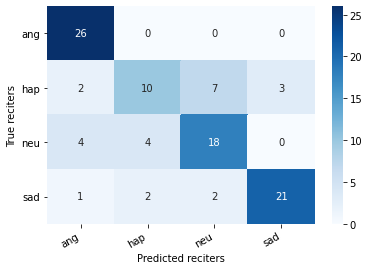

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True reciters')
  plt.xlabel('Predicted reciters');
cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index=label_names, columns=label_names)
show_confusion_matrix(df_cm)

# Prediction

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from transformers import AutoConfig, Wav2Vec2Processor

import librosa
import IPython.display as ipd
import numpy as np
import pandas as pd

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name_or_path = "/content/ckpts/EYASE_hubert/checkpoint-750"
config = AutoConfig.from_pretrained(model_name_or_path)
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name_or_path)
sampling_rate = feature_extractor.sampling_rate
model = HubertForSpeechClassification.from_pretrained(model_name_or_path).to(device)

In [ ]:
def speech_file_to_array_fn(path, sampling_rate):
    speech_array, _sampling_rate = torchaudio.load(path)
    resampler = torchaudio.transforms.Resample(_sampling_rate)
    speech = resampler(speech_array).squeeze().numpy()
    return speech


def predict(path, sampling_rate):
    speech = speech_file_to_array_fn(path, sampling_rate)
    features = feature_extractor(speech, sampling_rate=sampling_rate, return_tensors="pt", padding=True)

    input_values = features.input_values.to(device)

    with torch.no_grad():
        logits = model(input_values).logits

    scores = F.softmax(logits, dim=1).detach().cpu().numpy()[0]
    outputs = [{"Label": config.id2label[i], "Score": f"{round(score * 100, 3):.1f}%"} for i, score in enumerate(scores)]
    return outputs


STYLES = """
<style>
div.display_data {
    margin: 0 auto;
    max-width: 500px;
}
table.xxx {
    margin: 50px !important;
    float: right !important;
    clear: both !important;
}
table.xxx td {
    min-width: 300px !important;
    text-align: center !important;
}
</style>
""".strip()

def prediction(df_row):
    path, label = df_row["path"], df_row["emotion"]
    df = pd.DataFrame([{"Emotion": label, "Sentence": "    "}])
    setup = {
        'border': 2,
        'show_dimensions': True,
        'justify': 'center',
        'classes': 'xxx',
        'escape': False,
    }
    ipd.display(ipd.HTML(STYLES + df.to_html(**setup) + "<br />"))
    speech, sr = torchaudio.load(path)
    speech = speech[0].numpy().squeeze()
    speech = librosa.resample(np.asarray(speech), sr, sampling_rate)
    ipd.display(ipd.Audio(data=np.asarray(speech), autoplay=True, rate=sampling_rate))

    outputs = predict(path, sampling_rate)
    r = pd.DataFrame(outputs)
    ipd.display(ipd.HTML(STYLES + r.to_html(**setup) + "<br />"))

In [ ]:
test = pd.read_csv("/content/data/test.csv", sep="\t")
test.head()

In [ ]:
prediction(test.iloc[0])

In [ ]:
prediction(test.iloc[1])

In [ ]:
prediction(test.iloc[2])